<a href="https://colab.research.google.com/github/julietlawton/bike-sharing-customer-estimation/blob/main/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [95]:
%%capture
!pip install ucimlrepo
!pip install dcor

In [96]:
%%capture
# NOTE: Have to restart the kernel after running this
!pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip

In [97]:
# Juliet's imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import dcor
from datetime import datetime
from ydata_profiling import ProfileReport
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Concatenate
from tensorflow.keras.layers import Dropout, Activation, BatchNormalization, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [98]:
# Albert's imports
import tensorflow as tf

In [99]:
# Fetch dataset from UCI repo
bike_sharing_dataset = fetch_ucirepo(id=275)

# Print variable info
with pd.option_context('display.max_colwidth', None):
  print(bike_sharing_dataset.variables)

# Get full dataset as a dataframe
bike_sharing_df = bike_sharing_dataset.data.original

          name     role         type demographic  \
0      instant       ID      Integer        None   
1       dteday  Feature         Date        None   
2       season  Feature  Categorical        None   
3           yr  Feature  Categorical        None   
4         mnth  Feature  Categorical        None   
5           hr  Feature  Categorical        None   
6      holiday  Feature       Binary        None   
7      weekday  Feature  Categorical        None   
8   workingday  Feature       Binary        None   
9   weathersit  Feature  Categorical        None   
10        temp  Feature   Continuous        None   
11       atemp  Feature   Continuous        None   
12         hum  Feature   Continuous        None   
13   windspeed  Feature   Continuous        None   
14      casual    Other      Integer        None   
15  registered    Other      Integer        None   
16         cnt   Target      Integer        None   

                                                               

# EDA and Preprocessing

In [100]:
# View first 5 entries of the dataset
bike_sharing_df.head()

instant      dteday  season  yr  mnth  hr  holiday  weekday  workingday  \
0        1  2011-01-01       1   0     1   0        0        6           0   
1        2  2011-01-01       1   0     1   1        0        6           0   
2        3  2011-01-01       1   0     1   2        0        6           0   
3        4  2011-01-01       1   0     1   3        0        6           0   
4        5  2011-01-01       1   0     1   4        0        6           0   

   weathersit  temp   atemp   hum  windspeed  casual  registered  cnt  
0           1  0.24  0.2879  0.81        0.0       3          13   16  
1           1  0.22  0.2727  0.80        0.0       8          32   40  
2           1  0.22  0.2727  0.80        0.0       5          27   32  
3           1  0.24  0.2879  0.75        0.0       3          10   13  
4           1  0.24  0.2879  0.75        0.0       0           1    1

In [101]:
# View descriptive statistics for each feature in the dataset
bike_sharing_df.describe()

instant        season            yr          mnth            hr  \
count  17379.0000  17379.000000  17379.000000  17379.000000  17379.000000   
mean    8690.0000      2.501640      0.502561      6.537775     11.546752   
std     5017.0295      1.106918      0.500008      3.438776      6.914405   
min        1.0000      1.000000      0.000000      1.000000      0.000000   
25%     4345.5000      2.000000      0.000000      4.000000      6.000000   
50%     8690.0000      3.000000      1.000000      7.000000     12.000000   
75%    13034.5000      3.000000      1.000000     10.000000     18.000000   
max    17379.0000      4.000000      1.000000     12.000000     23.000000   

            holiday       weekday    workingday    weathersit          temp  \
count  17379.000000  17379.000000  17379.000000  17379.000000  17379.000000   
mean       0.028770      3.003683      0.682721      1.425283      0.496987   
std        0.167165      2.005771      0.465431      0.639357      0.192556   
min        0.000000      0.000000      0.000000      1.000000      0.020000   
25%        0.000000      1.000000      0.000000      1.000000      0.340000   
50%        0.000000      3.000000      1.000000      1.000000      0.500000   
75%        0.000000      5.000000      1.000000      2.000000      0.660000   
max        1.000000      6.000000      1.000000      4.000000      1.000000   

              atemp           hum     windspeed        casual    registered  \
count  17379.000000  17379.000000  17379.000000  17379.000000  17379.000000   
mean       0.475775      0.627229      0.190098     35.676218    153.786869   
std        0.171850      0.192930      0.122340     49.305030    151.357286   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.333300      0.480000      0.104500      4.000000     34.000000   
50%        0.484800      0.630000      0.194000     17.000000    115.000000   
75%        0.621200      0.780000      0.253700     48.000000    220.000000   
max        1.000000      1.000000      0.850700    367.000000    886.000000   

                cnt  
count  17379.000000  
mean     189.463088  
std      181.387599  
min        1.000000  
25%       40.000000  
50%      142.000000  
75%      281.000000  
max      977.000000

In [102]:
# Examine unique values for each category
for col in ['season', 'mnth', 'hr', 'weekday', 'weathersit']:
  print(f'Category: {col}')
  print(f'Values: {bike_sharing_df[col].unique()}')

Category: season
Values: [1 2 3 4]
Category: mnth
Values: [ 1  2  3  4  5  6  7  8  9 10 11 12]
Category: hr
Values: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Category: weekday
Values: [6 0 1 2 3 4 5]
Category: weathersit
Values: [1 2 3 4]


In [103]:
# Shift categorical variables to start at 0
bike_sharing_df['season'] = bike_sharing_df['season'] - 1
bike_sharing_df['mnth'] = bike_sharing_df['mnth'] - 1
bike_sharing_df['weathersit'] = bike_sharing_df['weathersit'] - 1

In [104]:
# Convert categorical variables to be of type category
bike_sharing_df['hr'] = bike_sharing_df['hr'].astype('category')
bike_sharing_df['mnth'] = bike_sharing_df['mnth'].astype('category')
bike_sharing_df['weekday'] = bike_sharing_df['weekday'].astype('category')
bike_sharing_df['season'] = bike_sharing_df['season'].astype('category')
bike_sharing_df['weathersit'] = bike_sharing_df['weathersit'].astype('category')

In [105]:
# Drop instant because it is an ID
bike_sharing_df.drop(columns=['instant'], axis=1, inplace=True)

# Drop yr because it only tells us if the year is 2011 or 2012
bike_sharing_df.drop(columns=['yr'], axis=1, inplace=True)

In [106]:
# Create a new datetime column
def getdatetime(row):
    year, month, day = row[0].split('-')
    hour = row[1]
    return datetime(int(year), int(month), int(day), int(hour))

bike_sharing_df['datetime'] = bike_sharing_df[['dteday', 'hr']].apply(getdatetime, axis=1)

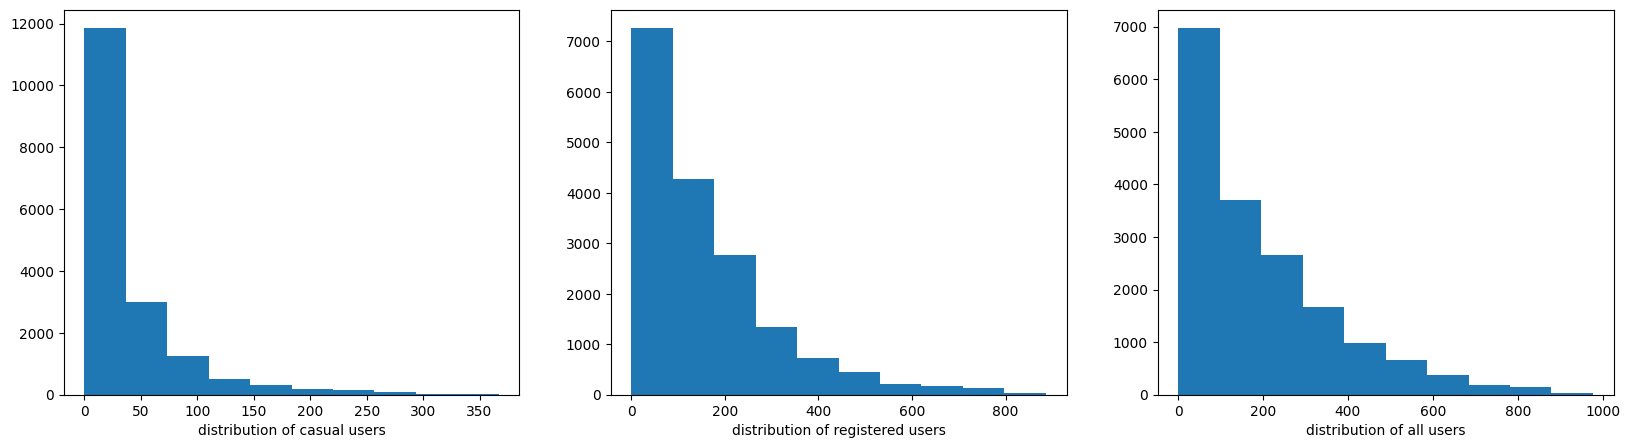

In [107]:
# Examine the distribution of possible target variables
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))
ax1.hist(bike_sharing_df['casual'])
ax1.set_xlabel('distribution of casual users')

ax2.hist(bike_sharing_df['registered'])
ax2.set_xlabel('distribution of registered users')

ax3.hist(bike_sharing_df['cnt'])
ax3.set_xlabel('distribution of all users')
plt.show()

In [108]:
# Introduce a new feature that represents the ratio of casual to registered users
bike_sharing_df['casual_vs_registered'] = bike_sharing_df['casual']/bike_sharing_df['registered']

In [109]:
# Check distribution for new variable
print(bike_sharing_df['casual_vs_registered'].describe())

count    1.737900e+04
mean              inf
std               NaN
min      0.000000e+00
25%      6.779661e-02
50%      1.721854e-01
75%      3.400000e-01
max               inf
Name: casual_vs_registered, dtype: float64


In [110]:
# Handle cases where either casual or registered is 0 by replacing with 1s
casual_temp = bike_sharing_df['casual'].replace(0, 1)
registered_temp = bike_sharing_df['registered'].replace(0, 1)

bike_sharing_df['casual_vs_registered'] = casual_temp/registered_temp
bike_sharing_df['log_casual_vs_registered'] = np.log1p(bike_sharing_df['casual_vs_registered'])

count    17379.000000
mean         0.272440
std          0.283652
min          0.002237
25%          0.091500
50%          0.194030
75%          0.358491
max          7.000000
Name: casual_vs_registered, dtype: float64
count    17379.000000
mean         0.222583
std          0.180896
min          0.002235
25%          0.087553
50%          0.177334
75%          0.306374
max          2.079442
Name: log_casual_vs_registered, dtype: float64


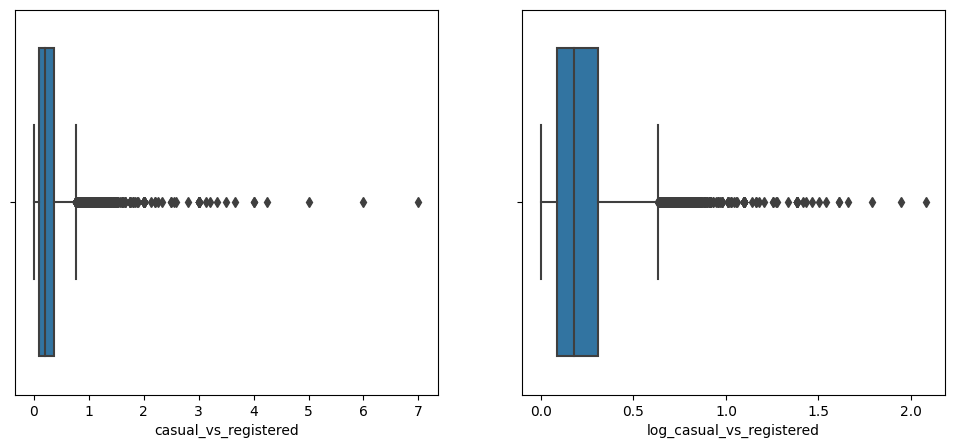

In [111]:
# Reinspect distribution
print(bike_sharing_df['casual_vs_registered'].describe())
print(bike_sharing_df['log_casual_vs_registered'].describe())

# Create box plots to visualize distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
sns.boxplot(x=bike_sharing_df['casual_vs_registered'], ax=ax1)

sns.boxplot(x=bike_sharing_df['log_casual_vs_registered'], ax=ax2)
plt.show()

In [112]:
# Examine data after changes
bike_sharing_df.head()

dteday season mnth hr  holiday weekday  workingday weathersit  temp  \
0  2011-01-01      0    0  0        0       6           0          0  0.24   
1  2011-01-01      0    0  1        0       6           0          0  0.22   
2  2011-01-01      0    0  2        0       6           0          0  0.22   
3  2011-01-01      0    0  3        0       6           0          0  0.24   
4  2011-01-01      0    0  4        0       6           0          0  0.24   

    atemp   hum  windspeed  casual  registered  cnt            datetime  \
0  0.2879  0.81        0.0       3          13   16 2011-01-01 00:00:00   
1  0.2727  0.80        0.0       8          32   40 2011-01-01 01:00:00   
2  0.2727  0.80        0.0       5          27   32 2011-01-01 02:00:00   
3  0.2879  0.75        0.0       3          10   13 2011-01-01 03:00:00   
4  0.2879  0.75        0.0       0           1    1 2011-01-01 04:00:00   

   casual_vs_registered  log_casual_vs_registered  
0              0.230769                  0.207639  
1              0.250000                  0.223144  
2              0.185185                  0.169899  
3              0.300000                  0.262364  
4              1.000000                  0.693147

In [113]:
# Generate profiling report on the cleaned data
profile = ProfileReport(bike_sharing_df, title="Pandas Profiling Report")
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [114]:
profile.to_file('./bike-sharing-profile.html')

/usr/local/lib/python3.10/dist-packages/ydata_profiling/profile_report.py:354: UserWarning: Try running command: 'pip install --upgrade Pillow' to avoid ValueError
  warnings.warn(


Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [115]:
# One hot encode categorical features
dummies = pd.get_dummies(bike_sharing_df[['season', 'mnth', 'hr', 'weekday', 'weathersit']], drop_first=False)
bike_sharing_df = pd.concat([bike_sharing_df, dummies], axis=1)

In [116]:
bike_sharing_df.head()

dteday season mnth hr  holiday weekday  workingday weathersit  temp  \
0  2011-01-01      0    0  0        0       6           0          0  0.24   
1  2011-01-01      0    0  1        0       6           0          0  0.22   
2  2011-01-01      0    0  2        0       6           0          0  0.22   
3  2011-01-01      0    0  3        0       6           0          0  0.24   
4  2011-01-01      0    0  4        0       6           0          0  0.24   

    atemp  ...  weekday_1  weekday_2  weekday_3  weekday_4  weekday_5  \
0  0.2879  ...          0          0          0          0          0   
1  0.2727  ...          0          0          0          0          0   
2  0.2727  ...          0          0          0          0          0   
3  0.2879  ...          0          0          0          0          0   
4  0.2879  ...          0          0          0          0          0   

  weekday_6  weathersit_0  weathersit_1  weathersit_2  weathersit_3  
0         1             1             0             0             0  
1         1             1             0             0             0  
2         1             1             0             0             0  
3         1             1             0             0             0  
4         1             1             0             0             0  

[5 rows x 69 columns]

In [117]:
bike_sharing_df.columns

Index(['dteday', 'season', 'mnth', 'hr', 'holiday', 'weekday', 'workingday',
       'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'casual',
       'registered', 'cnt', 'datetime', 'casual_vs_registered',
       'log_casual_vs_registered', 'season_0', 'season_1', 'season_2',
       'season_3', 'mnth_0', 'mnth_1', 'mnth_2', 'mnth_3', 'mnth_4', 'mnth_5',
       'mnth_6', 'mnth_7', 'mnth_8', 'mnth_9', 'mnth_10', 'mnth_11', 'hr_0',
       'hr_1', 'hr_2', 'hr_3', 'hr_4', 'hr_5', 'hr_6', 'hr_7', 'hr_8', 'hr_9',
       'hr_10', 'hr_11', 'hr_12', 'hr_13', 'hr_14', 'hr_15', 'hr_16', 'hr_17',
       'hr_18', 'hr_19', 'hr_20', 'hr_21', 'hr_22', 'hr_23', 'weekday_0',
       'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
       'weekday_6', 'weathersit_0', 'weathersit_1', 'weathersit_2',
       'weathersit_3'],
      dtype='object')

In [118]:
# Distance correlation for casual and continuous independent variables
print("Correlations for casual:")
print(f"Correlation for temp and casual: {dcor.distance_correlation(bike_sharing_df['temp'], bike_sharing_df['casual'])}")

print(f"Correlation for atemp and casual: {dcor.distance_correlation(bike_sharing_df['atemp'], bike_sharing_df['casual'])}")

print(f"Correlation for hum and casual: {dcor.distance_correlation(bike_sharing_df['hum'], bike_sharing_df['casual'])}")

print(f"Correlation for windspeed and casual: {dcor.distance_correlation(bike_sharing_df['windspeed'], bike_sharing_df['casual'])}")

# Distance correlation for registered and continuous independent variables
print("Correlations for registered:")
print(f"Correlation for temp and registered: {dcor.distance_correlation(bike_sharing_df['temp'], bike_sharing_df['registered'])}")

print(f"Correlation for atemp and registered: {dcor.distance_correlation(bike_sharing_df['atemp'], bike_sharing_df['registered'])}")

print(f"Correlation for hum and registered: {dcor.distance_correlation(bike_sharing_df['hum'], bike_sharing_df['registered'])}")

print(f"Correlation for windspeed and registered: {dcor.distance_correlation(bike_sharing_df['windspeed'], bike_sharing_df['registered'])}")

# Distance correlation for cnt and continuous independent variables
print("Correlations for cnt:")
print(f"Correlation for temp and cnt: {dcor.distance_correlation(bike_sharing_df['temp'], bike_sharing_df['cnt'])}")

print(f"Correlation for atemp and cnt: {dcor.distance_correlation(bike_sharing_df['atemp'], bike_sharing_df['cnt'])}")

print(f"Correlation for hum and cnt: {dcor.distance_correlation(bike_sharing_df['hum'], bike_sharing_df['cnt'])}")

print(f"Correlation for windspeed and cnt: {dcor.distance_correlation(bike_sharing_df['windspeed'], bike_sharing_df['cnt'])}")

# Distance correlation for casual_vs_registered and continuous independent variables
print("Correlations for casual_vs_registered:")
print(f"Correlation for temp and casual_vs_registered: {dcor.distance_correlation(bike_sharing_df['temp'], bike_sharing_df['casual_vs_registered'])}")

print(f"Correlation for atemp and casual_vs_registered: {dcor.distance_correlation(bike_sharing_df['atemp'], bike_sharing_df['casual_vs_registered'])}")

print(f"Correlation for hum and casual_vs_registered: {dcor.distance_correlation(bike_sharing_df['hum'], bike_sharing_df['casual_vs_registered'])}")

print(f"Correlation for windspeed and casual_vs_registered: {dcor.distance_correlation(bike_sharing_df['windspeed'], bike_sharing_df['casual_vs_registered'])}")

/usr/local/lib/python3.10/dist-packages/dcor/_fast_dcov_avl.py:554: UserWarning: Falling back to uncompiled AVL fast distance covariance terms because of TypeError exception raised: No matching definition for argument type(s) array(float64, 1d, C), array(int64, 1d, C), bool. Rembember: only floating point values can be used in the compiled implementations.
  warnings.warn(


Correlations for casual:


/usr/local/lib/python3.10/dist-packages/dcor/_dcor_internals.py:188: RuntimeWarning: overflow encountered in scalar multiply
  third_term = a_total_sum * b_total_sum / n_samples


Correlation for temp and casual: 0.4381158070343228
Correlation for atemp and casual: 0.43990207507786117
Correlation for hum and casual: 0.3129375639572588
Correlation for windspeed and casual: 0.09809134516206383
Correlations for registered:
Correlation for temp and registered: 0.2894652469831514
Correlation for atemp and registered: 0.292248937599841
Correlation for hum and registered: 0.25670994855052054
Correlation for windspeed and registered: 0.09102353010983961
Correlations for cnt:
Correlation for temp and cnt: 0.344684563080449
Correlation for atemp and cnt: 0.3476517748735718
Correlation for hum and cnt: 0.2840572726062154
Correlation for windspeed and cnt: 0.09726780617032511
Correlations for casual_vs_registered:
Correlation for temp and casual_vs_registered: 0.3095473112002956
Correlation for atemp and casual_vs_registered: 0.3112230308321759
Correlation for hum and casual_vs_registered: 0.1152993234228237
Correlation for windspeed and casual_vs_registered: 0.023171836523

# Time Series Forecasting:
Reference: https://www.tensorflow.org/tutorials/structured_data/time_series

In [136]:
# Create a copy of the data for time series forecasting
time_series_df = bike_sharing_df.copy()
time_series_df = time_series_df[['temp', 'atemp', 'hum', 'windspeed', 'cnt', 'datetime']]

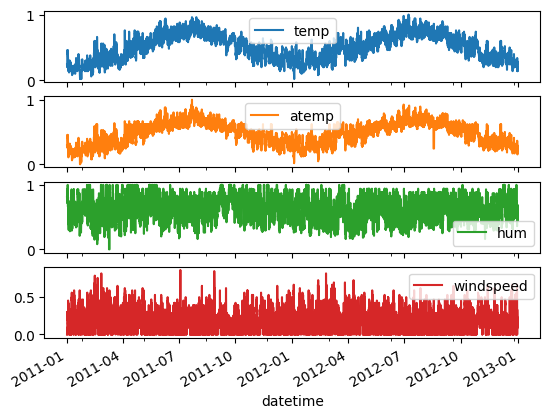

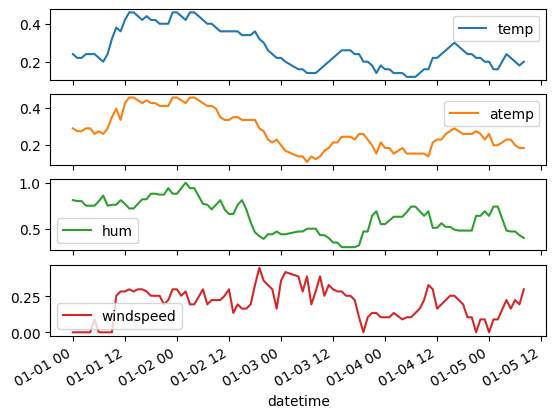

In [137]:
# Plot feature evolution over time
plot_cols = ['temp', 'atemp', 'hum', 'windspeed']
plot_features = bike_sharing_df[plot_cols]
plot_features.index = bike_sharing_df['datetime']
_ = plot_features.plot(subplots=True)

# Plot just the first 100 datapoints
plot_features = bike_sharing_df[plot_cols][:100]
plot_features.index = bike_sharing_df['datetime'][:100]
_ = plot_features.plot(subplots=True)

In [138]:
# Split data 70% training, 20% validation, 10% testing
column_indices = {name: i for i, name in enumerate(time_series_df.columns)}

n = len(time_series_df)
train_df = time_series_df[0:int(n*0.7)].copy()
val_df = time_series_df[int(n*0.7):int(n*0.9)].copy()
test_df = time_series_df[int(n*0.9):].copy()

# Create a copy of the true counts for the test set with datetime preserved
true_labels = test_df[['datetime', 'cnt']].copy()

# Drop datetime because we won't use it to train the model
time_series_df.drop(columns=['datetime'], inplace=True)
train_df.drop(columns=['datetime'], inplace=True)
val_df.drop(columns=['datetime'], inplace=True)
test_df.drop(columns=['datetime'], inplace=True)

num_features = time_series_df.shape[1]

In [139]:
# Compute the mean and standard deviation for just the training set
train_mean = train_df.mean()
train_std = train_df.std()

# Use the mean and std to normalize the data splits
train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

train_df.head()

temp     atemp       hum  windspeed       cnt
0 -1.209897 -0.961929  0.912788  -1.568731 -0.943336
1 -1.315972 -1.051596  0.862856  -1.568731 -0.786041
2 -1.315972 -1.051596  0.862856  -1.568731 -0.838472
3 -1.209897 -0.961929  0.613199  -1.568731 -0.962998
4 -1.209897 -0.961929  0.613199  -1.568731 -1.041645

In [140]:
# Define a function to return the predictions to their original scale
def reverse_normalization(normalized_counts, mean, std):
  return normalized_counts * std + mean

In [141]:
# Test reverse normalization function
cnt_unnormalized = reverse_normalization(train_df['cnt'], train_mean['cnt'], train_std['cnt'])
print(cnt_unnormalized.head())
print(bike_sharing_df['cnt'].head())

0    16.0
1    40.0
2    32.0
3    13.0
4     1.0
Name: cnt, dtype: float64
0    16
1    40
2    32
3    13
4     1
Name: cnt, dtype: int64


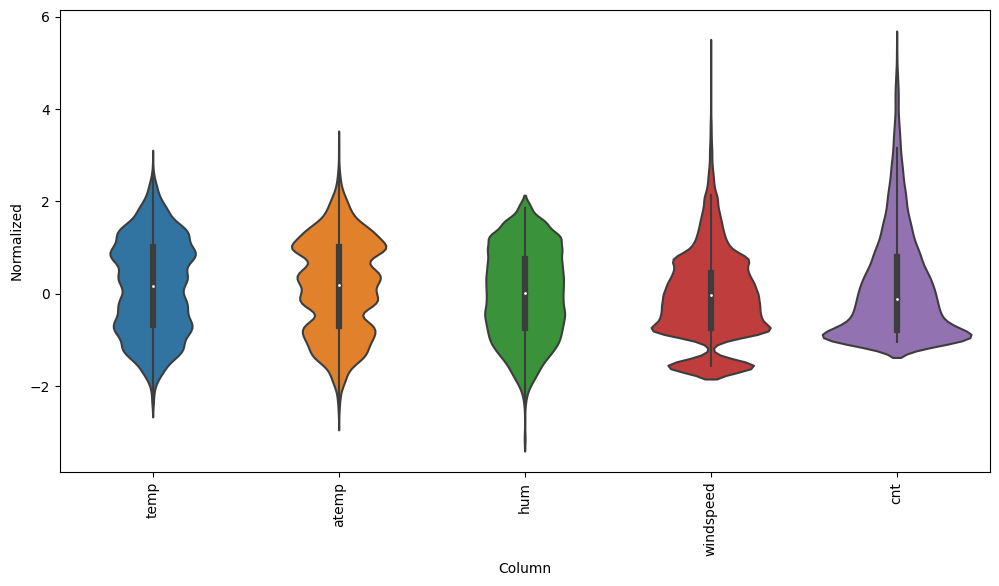

In [142]:
# Create a violin plot to visualize the distribution of the normalized features
df_std = (time_series_df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(time_series_df.keys(), rotation=90)

In [143]:
# Window definition
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [144]:
# This window will cause the model to make a single prediction one hour into the future using 24 hours of history
# input_width: how much history is used to make a prediction
# shift: how far in the future the prediction is made
# label_width: how many predictions are made
one_hour_window = WindowGenerator(input_width=24, label_width=1, shift=1, label_columns=['cnt'])
print(one_hour_window)

# This window will generate non-overlapping predictions for the given label width
discrete_window = WindowGenerator(input_width=12, label_width=12, shift=12, label_columns=['cnt'])
print(discrete_window)

# This window will generate continuous overlapping predictions for every hour
continuous_window = WindowGenerator(input_width=24, label_width=24, shift=1, label_columns=['cnt'])
print(continuous_window)

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24]
Label column name(s): ['cnt']
Total window size: 24
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11]
Label indices: [12 13 14 15 16 17 18 19 20 21 22 23]
Label column name(s): ['cnt']
Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['cnt']


In [145]:
# Split the windows into input features and resulting labels
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [146]:
# Example using single prediction window
example_window_discrete = tf.stack([np.array(train_df[:discrete_window.total_window_size]),
                           np.array(train_df[100:100+discrete_window.total_window_size]),
                           np.array(train_df[200:200+discrete_window.total_window_size])])

example_inputs_discrete, example_labels_discrete = discrete_window.split_window(example_window_discrete)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window_discrete.shape}')
print(f'Inputs shape: {example_inputs_discrete.shape}')
print(f'Labels shape: {example_labels_discrete.shape}')


# Example using continuous prediction window
example_window_continuous = tf.stack([np.array(train_df[:continuous_window.total_window_size]),
                           np.array(train_df[100:100+continuous_window.total_window_size]),
                           np.array(train_df[200:200+continuous_window.total_window_size])])

example_inputs_continuous, example_labels_continuous = continuous_window.split_window(example_window_continuous)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window_continuous.shape}')
print(f'Inputs shape: {example_inputs_continuous.shape}')
print(f'Labels shape: {example_labels_continuous.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 24, 5)
Inputs shape: (3, 12, 5)
Labels shape: (3, 12, 1)
All shapes are: (batch, time, features)
Window shape: (3, 25, 5)
Inputs shape: (3, 24, 5)
Labels shape: (3, 24, 1)


In [147]:
# Plotting function for plotting labels and predictions for a window
def plot(self, model=None, plot_col='cnt', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [original scale]')
    inputs_original_scale = reverse_normalization(inputs[n, :, plot_col_index], train_mean['cnt'], train_std['cnt'])
    plt.plot(self.input_indices, inputs_original_scale,
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    labels_original_scale = reverse_normalization(labels[n, :, label_col_index], train_mean['cnt'], train_std['cnt'])
    plt.scatter(self.label_indices, labels_original_scale,
                edgecolors='k', label='Labels', c='#2ca02c', s=64)

    if model is not None:
      predictions = model(inputs)
      predictions_original_scale = reverse_normalization(predictions[n, :, label_col_index], train_mean['cnt'], train_std['cnt'])
      plt.scatter(self.label_indices, predictions_original_scale,
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

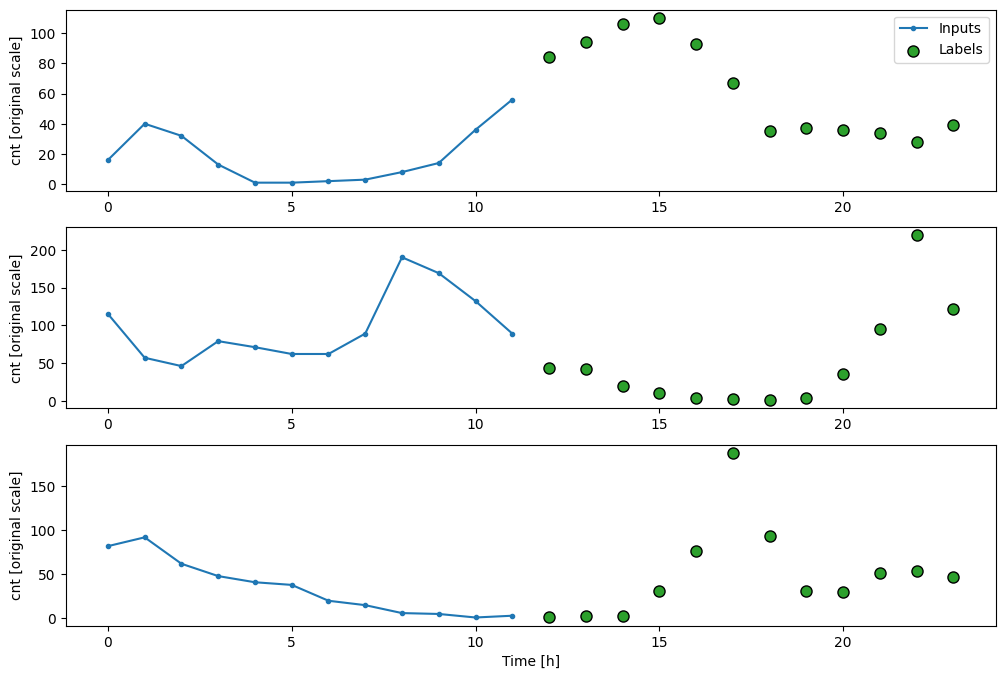

In [148]:
# Test plotting function with example inputs and labels for single prediction window
discrete_window.example = example_inputs_discrete, example_labels_discrete
discrete_window.plot()

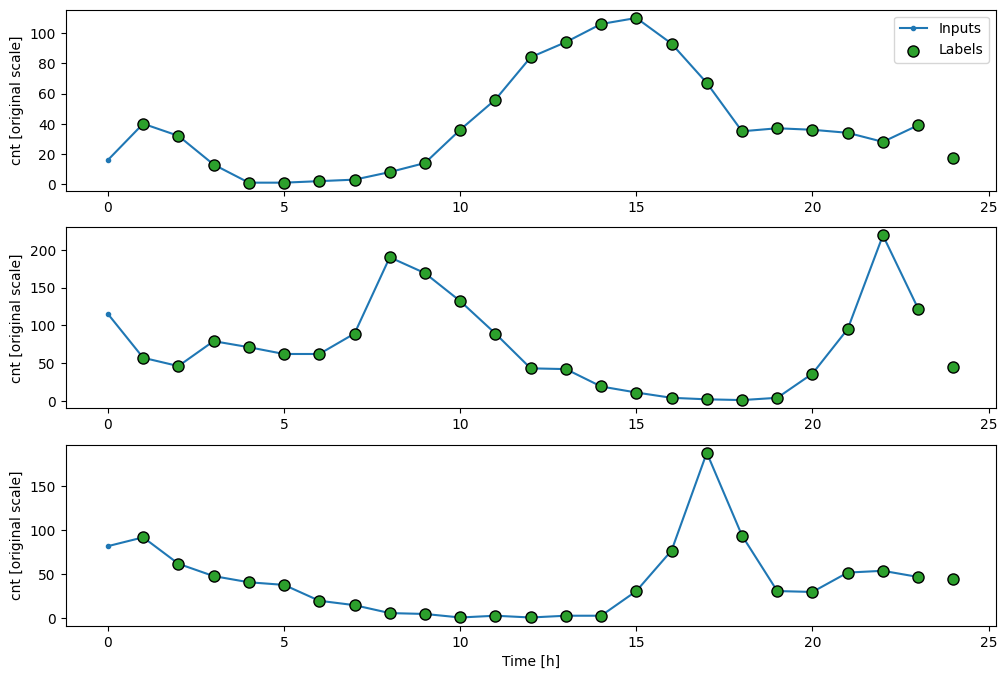

In [149]:
# Test plotting function with example inputs and labels for single prediction window
continuous_window.example = example_inputs_continuous, example_labels_continuous
continuous_window.plot()

In [150]:
# Create a tensorflow time series dataset from a dataframe
def make_dataset(self, data, shuffle=False):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=shuffle,
      batch_size=128)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [151]:
# Create tf datasets for each of the data splits
@property
def train(self):
  return self.make_dataset(self.train_df, shuffle=True)

@property
def val(self):
  return self.make_dataset(self.val_df, shuffle=False)

@property
def test(self):
  return self.make_dataset(self.test_df, shuffle=False)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [152]:
# Each element is an (inputs, label) pair.
one_hour_window.train.element_spec

(TensorSpec(shape=(None, 24, 5), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [153]:
for example_inputs, example_labels in one_hour_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (128, 24, 5)
Labels shape (batch, time, features): (128, 1, 1)


In [154]:
# Create objects for saving evaluation metrics
val_performance = {}
performance = {}

## Baseline Model:
Reference: https://www.tensorflow.org/tutorials/structured_data/time_series#baseline

In [155]:
# Baseline model class
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [156]:
# Train and evaluate the model
baseline = Baseline(label_index=column_indices['cnt'])

baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

val_performance['Baseline'] = baseline.evaluate(continuous_window.val)
performance['Baseline'] = baseline.evaluate(continuous_window.test, verbose=0)

27/27 [==============================] - 1s 11ms/step - loss: 0.8376 - mean_absolute_error: 0.6226


In [157]:
print('Input shape:', continuous_window.example[0].shape)
print('Output shape:', baseline(continuous_window.example[0]).shape)

Input shape: (128, 24, 5)
Output shape: (128, 24, 1)


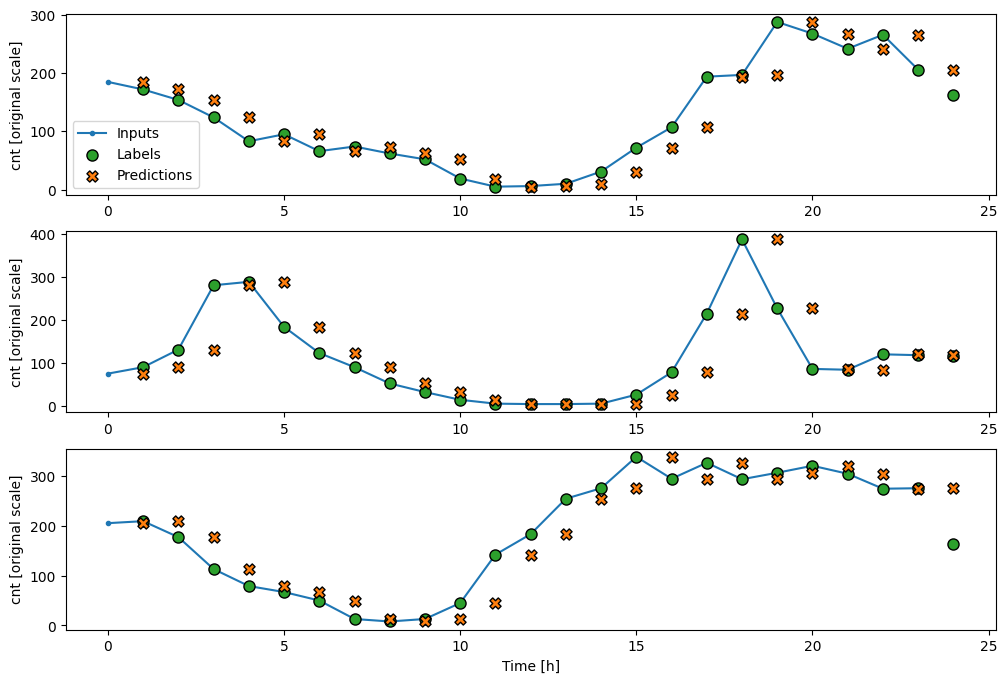

In [158]:
# Plot predictions
continuous_window.plot(baseline)

In [159]:
#Set max epochs for all models
MAX_EPOCHS = 30

# Define method for compiling and fitting a model
def compile_and_fit(model, window, patience=2):
  # Add early stopping callback
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])

  return history

## RNN LSTM:
Reference: https://www.tensorflow.org/tutorials/structured_data/time_series#recurrent_neural_network

In [160]:
# Define a lstm model for time series forecasting
# return_sequences: layer returns output for each input if true, else only returns output of the final time step
lstm_model = Sequential([
    LSTM(16, return_sequences=True),
    Dense(units=1)
])

In [161]:
# Compile and fit the model and save the performance metrics
history = compile_and_fit(lstm_model, continuous_window)

val_performance['LSTM'] = lstm_model.evaluate(continuous_window.val)
performance['LSTM'] = lstm_model.evaluate(continuous_window.test, verbose=0)

Epoch 1/30
95/95 [==============================] - 6s 31ms/step - loss: 0.5803 - mean_absolute_error: 0.5594 - val_loss: 1.1732 - val_mean_absolute_error: 0.7167
Epoch 2/30
95/95 [==============================] - 3s 31ms/step - loss: 0.3502 - mean_absolute_error: 0.4121 - val_loss: 0.7246 - val_mean_absolute_error: 0.5606
Epoch 3/30
95/95 [==============================] - 3s 35ms/step - loss: 0.2385 - mean_absolute_error: 0.3287 - val_loss: 0.5229 - val_mean_absolute_error: 0.4751
Epoch 4/30
95/95 [==============================] - 3s 26ms/step - loss: 0.1873 - mean_absolute_error: 0.2882 - val_loss: 0.4515 - val_mean_absolute_error: 0.4453
Epoch 5/30
95/95 [==============================] - 2s 23ms/step - loss: 0.1609 - mean_absolute_error: 0.2688 - val_loss: 0.4105 - val_mean_absolute_error: 0.4276
Epoch 6/30
95/95 [==============================] - 3s 30ms/step - loss: 0.1472 - mean_absolute_error: 0.2572 - val_loss: 0.3926 - val_mean_absolute_error: 0.4190
Epoch 7/30
95/95 [====

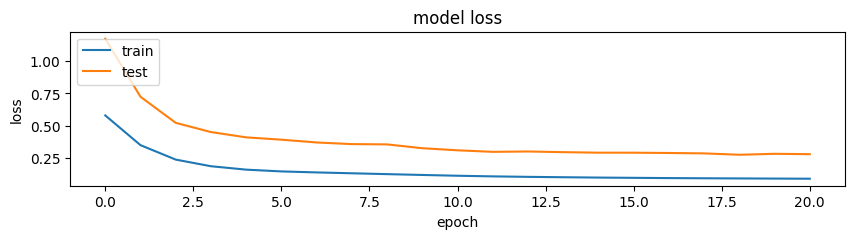

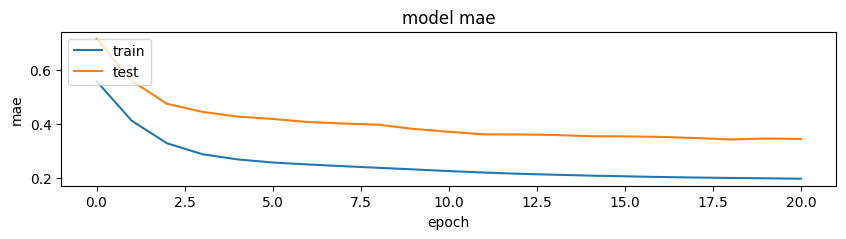

In [164]:
# Plot learning curves
plt.figure(figsize=(10, 2))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.figure(figsize=(10, 2))
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('model mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

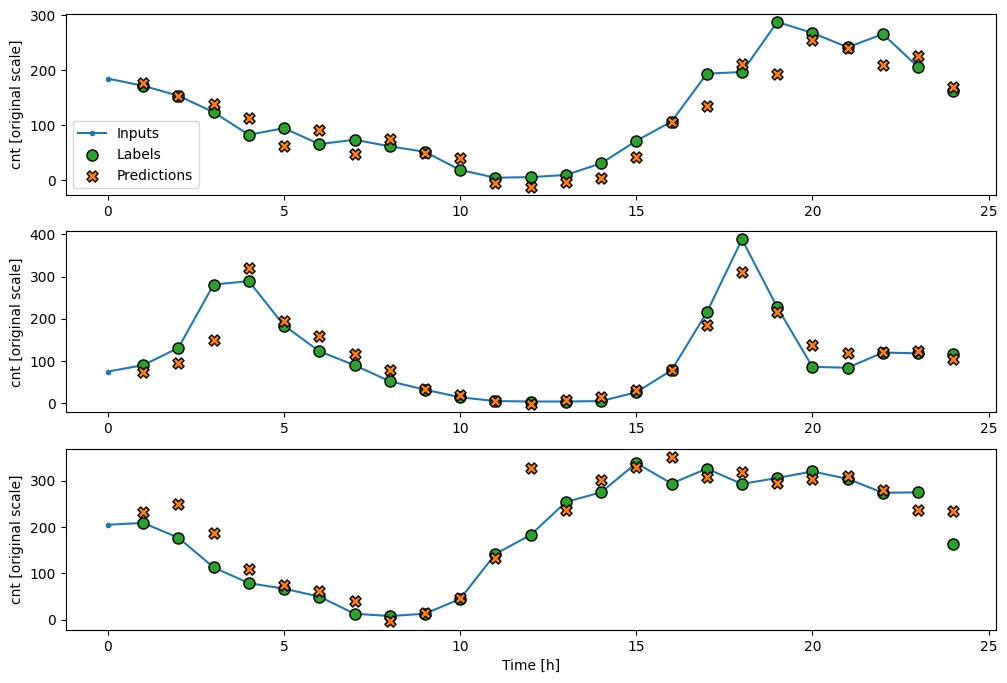

In [165]:
# Plot predictions
continuous_window.plot(lstm_model)

Baseline    : 0.4599
LSTM        : 0.2494


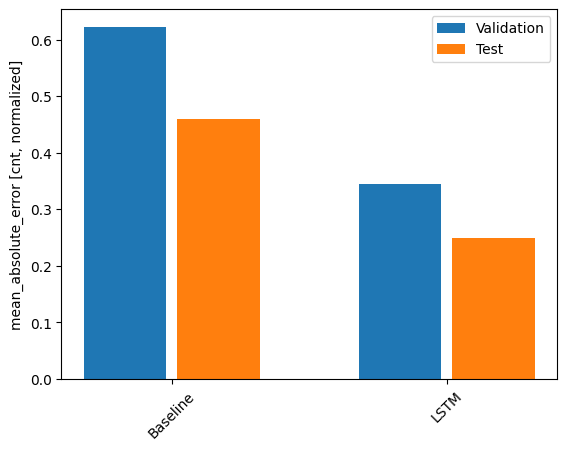

In [171]:
# Use bar charts to compare performance between baseline and lstm (mae)
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [cnt, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

for name, value in performance.items():
  print(f'{name:12s}: {value[1]:0.4f}')

Baseline    : 0.5198
LSTM        : 0.1594


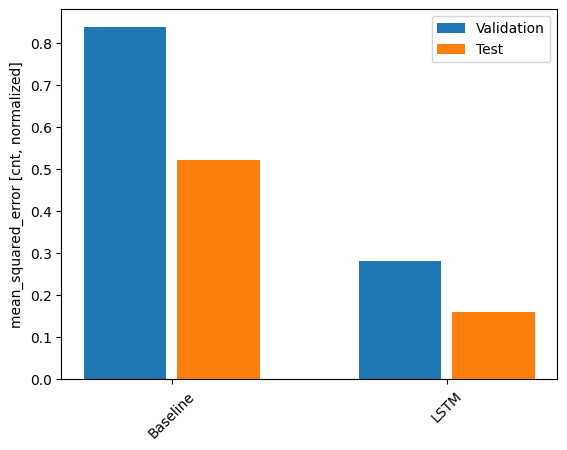

In [172]:
# Use bar charts to compare performance between baseline and lstm (mse)
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_squared_error'
metric_index = lstm_model.metrics_names.index('loss')
val_mse = [v[metric_index] for v in val_performance.values()]
test_mse = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_squared_error [cnt, normalized]')
plt.bar(x - 0.17, val_mse, width, label='Validation')
plt.bar(x + 0.17, test_mse, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

for name, value in performance.items():
    print(f'{name:12s}: {value[0]:0.4f}')

In [173]:
# Generate predictions for the test set
y_pred = lstm_model.predict(continuous_window.test)

14/14 [==============================] - 1s 11ms/step


In [174]:
# Reshape predictions
reshaped_windows = y_pred.reshape(y_pred.shape[0], y_pred.shape[1])

# Create object to hold final predictions and add first window of predictions
predicted_values = [pred for pred in reshaped_windows[0]]

# Create object to hold the number of predictions for each timestep to average them
num_predictions = [1 for item in predicted_values]

# Iterate over every window and aggregate the predictions that overlap to get one
# final prediction for timestamp
for i in range(1, len(reshaped_windows)):
  window = reshaped_windows[i]

  for j in range(reshaped_windows.shape[1]):
    pred_index = i+j

    # If a prediction already exists at this index, add the new prediction,
    # else extend the predictions
    if pred_index < len(predicted_values):
      predicted_values[pred_index] += window[j]
      num_predictions[pred_index] += 1
    else:
      predicted_values.append(window[j])
      num_predictions.append(1)

# Aggregate predictions for each step by averaging them
aggregated_predictions = [
    np.maximum(0, round(reverse_normalization(
        preds_sum/num_preds,
        train_mean['cnt'],
        train_std['cnt'])))
    for preds_sum, num_preds
    in zip(predicted_values, num_predictions)
]

In [175]:
# Slice off first row of the true labels because no prediction is generated for the first timestep
lstm_predictions_df = true_labels.iloc[1:].reset_index(drop=True)
lstm_predictions_df.head()

datetime  cnt
0 2012-10-18 23:00:00  117
1 2012-10-19 00:00:00   56
2 2012-10-19 01:00:00   16
3 2012-10-19 02:00:00   10
4 2012-10-19 03:00:00    5

In [176]:
# Add the prediction for each label
lstm_predictions_df['predicted'] = aggregated_predictions
lstm_predictions_df.head()

datetime  cnt  predicted
0 2012-10-18 23:00:00  117        239
1 2012-10-19 00:00:00   56        103
2 2012-10-19 01:00:00   16         46
3 2012-10-19 02:00:00   10         17
4 2012-10-19 03:00:00    5         19

In [177]:
# Export the predictions
lstm_predictions_df.to_csv("lstm_predictions.csv")

# Predicting Casual Users

In [178]:
# Select features for the model
features = [
    'holiday',
    'workingday',
    'temp',
    'atemp',
    'hum',
    'windspeed',
    'season_0',
    'season_1',
    'season_2',
    'season_3',
    'mnth_0',
    'mnth_1',
    'mnth_2',
    'mnth_3',
    'mnth_4',
    'mnth_5',
    'mnth_6',
    'mnth_7',
    'mnth_8',
    'mnth_9',
    'mnth_10',
    'mnth_11',
    'hr_0',
    'hr_1',
    'hr_2',
    'hr_3',
    'hr_4',
    'hr_5',
    'hr_6',
    'hr_7',
    'hr_8',
    'hr_9',
    'hr_10',
    'hr_11',
    'hr_12',
    'hr_13',
    'hr_14',
    'hr_15',
    'hr_16',
    'hr_17',
    'hr_18',
    'hr_19',
    'hr_20',
    'hr_21',
    'hr_22',
    'hr_23',
    'weekday_0',
    'weekday_1',
    'weekday_2',
    'weekday_3',
    'weekday_4',
    'weekday_5',
    'weekday_6',
    'weathersit_0',
    'weathersit_1',
    'weathersit_2',
    'weathersit_3'
]

features_nonlinear = [
    'holiday',
    'workingday',
    'temp',
    'atemp',
    'hum',
    'windspeed',
    'season',
    'hr',
    'mnth',
    'weekday',
    'weathersit'
]

numerical_features = [
    'holiday',
    'workingday',
    'temp',
    'atemp',
    'hum',
    'windspeed',
]

target = 'casual'

In [179]:
# Define a method for calculating regression evaluation metrics
def evaluate_regression(y_test, y_pred):
  mse = mean_squared_error(y_true=y_test, y_pred=y_pred, squared=True)
  rmse = mean_squared_error(y_test, y_pred, squared=False)
  mae = mean_absolute_error(y_test, y_pred)
  r2 = r2_score(y_test, y_pred)
  return {'mse': mse, 'rmse': rmse, 'mae': mae, 'r2': r2}

In [180]:
# Save final week of data for analysis
data = bike_sharing_df.copy()
n = 24*7-1
last_week_df = data[-n:]
data = data[:-n]

In [181]:
# Get baseline metrics
X = data[features]
y = data[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Make naive predictions by just predicting the mean value
mean_target_value = np.mean(y_train)
naive_preds = np.full(shape=len(y_test), fill_value=mean_target_value)

print(evaluate_regression(y_test, naive_preds))

{'mse': 2511.75917055134, 'rmse': 50.117453751675576, 'mae': 34.501428311760456, 'r2': -3.662047429742188e-07}


In [182]:
# Create a linear regression model as a baseline model
X = data[features]
y = data[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(evaluate_regression(y_test, y_pred))

{'mse': 1061.1016214965148, 'rmse': 32.57455481655144, 'mae': 22.174048794655825, 'r2': 0.5775462781154908}


In [183]:
# Create the training splits for the neural network
X = data[features_nonlinear]
y = data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [184]:
# Create embeddings for categorical features
season_input = Input(shape=(1,), name='season')
hr_input = Input(shape=(1,), name='hr')
mnth_input = Input(shape=(1,), name='mnth')
weekday_input = Input(shape=(1,), name='weekday')
weathersit_input = Input(shape=(1,), name='weathersit')

season_embedding = Flatten()(Embedding(input_dim=4, output_dim=2, name='season_embedding')(season_input))
hr_embedding = Flatten()(Embedding(input_dim=24, output_dim=8, name='hr_embedding')(hr_input))
mnth_embedding = Flatten()(Embedding(input_dim=12, output_dim=4, name='mnth_embedding')(mnth_input))
weekday_embedding = Flatten()(Embedding(input_dim=7, output_dim=4, name='weekday_embedding')(weekday_input))
weathersit_embedding = Flatten()(Embedding(input_dim=4, output_dim=2, name='weathersit_embedding')(weathersit_input))

# Define input for non-categorical features
numerical_input = Input(shape=(len(numerical_features),), name='numerical')

# Combine all input features
all_features = Concatenate()([
    season_embedding,
    hr_embedding,
    mnth_embedding,
    weekday_embedding,
    weathersit_embedding,
    numerical_input
])

# Define model layers
layer1 = Dense(128)(all_features)
layer2 = BatchNormalization()(layer1)
layer3 = Activation(activation='relu')(layer2)
layer4 = Dense(64, activation='relu')(layer3)
output = Dense(1)(layer4)


# Create model and compile
model = Model(
    inputs=[
        season_input,
        hr_input,
        mnth_input,
        weekday_input,
        weathersit_input,
        numerical_input
    ],
    outputs=output
)

model.compile(optimizer=Adam(learning_rate=0.0001), loss='mae')
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 season (InputLayer)         [(None, 1)]                  0         []                            
                                                                                                  
 hr (InputLayer)             [(None, 1)]                  0         []                            
                                                                                                  
 mnth (InputLayer)           [(None, 1)]                  0         []                            
                                                                                                  
 weekday (InputLayer)        [(None, 1)]                  0         []                            
                                                                                              

In [185]:
# Fit the model
history = model.fit(
    [X_train['season'],
     X_train['hr'],
     X_train['mnth'],
     X_train['weekday'],
     X_train['weathersit'],
     X_train[numerical_features]],
    y_train,
    epochs=100,
    batch_size=128,
    validation_split=0.2,
    callbacks = [EarlyStopping(monitor='val_loss', min_delta=0.01, patience=5, verbose=0, mode='min'),
                 ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_delta=0.01)]
)

Epoch 1/100
87/87 [==============================] - 2s 7ms/step - loss: 35.1130 - val_loss: 35.1764 - lr: 1.0000e-04
Epoch 2/100
87/87 [==============================] - 0s 5ms/step - loss: 33.5038 - val_loss: 34.5030 - lr: 1.0000e-04
Epoch 3/100
87/87 [==============================] - 0s 4ms/step - loss: 31.7036 - val_loss: 33.2191 - lr: 1.0000e-04
Epoch 4/100
87/87 [==============================] - 0s 4ms/step - loss: 29.3312 - val_loss: 30.7772 - lr: 1.0000e-04
Epoch 5/100
87/87 [==============================] - 0s 4ms/step - loss: 26.0395 - val_loss: 26.5359 - lr: 1.0000e-04
Epoch 6/100
87/87 [==============================] - 0s 4ms/step - loss: 22.3487 - val_loss: 21.7414 - lr: 1.0000e-04
Epoch 7/100
87/87 [==============================] - 0s 4ms/step - loss: 19.4366 - val_loss: 18.6489 - lr: 1.0000e-04
Epoch 8/100
87/87 [==============================] - 0s 4ms/step - loss: 17.6045 - val_loss: 16.9041 - lr: 1.0000e-04
Epoch 9/100
87/87 [==============================] - 0s 

108/108 [==============================] - 0s 2ms/step
{'mse': 434.8271851590702, 'rmse': 20.852510284353542, 'mae': 11.190381572144974, 'r2': 0.826883345548052}


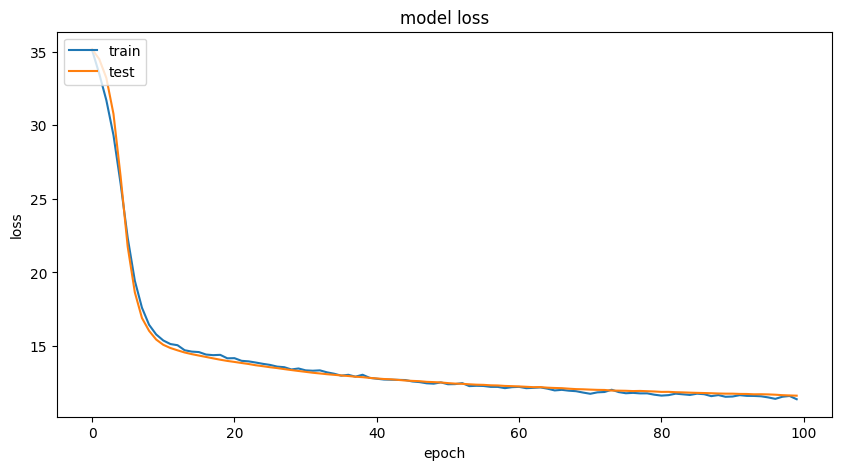

In [186]:
# Evaluate the model
y_pred = model.predict(
    [X_test['season'],
     X_test['hr'],
     X_test['mnth'],
     X_test['weekday'],
     X_test['weathersit'],
     X_test[numerical_features]
])

print(evaluate_regression(y_test, y_pred))

# Plot learning curves
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

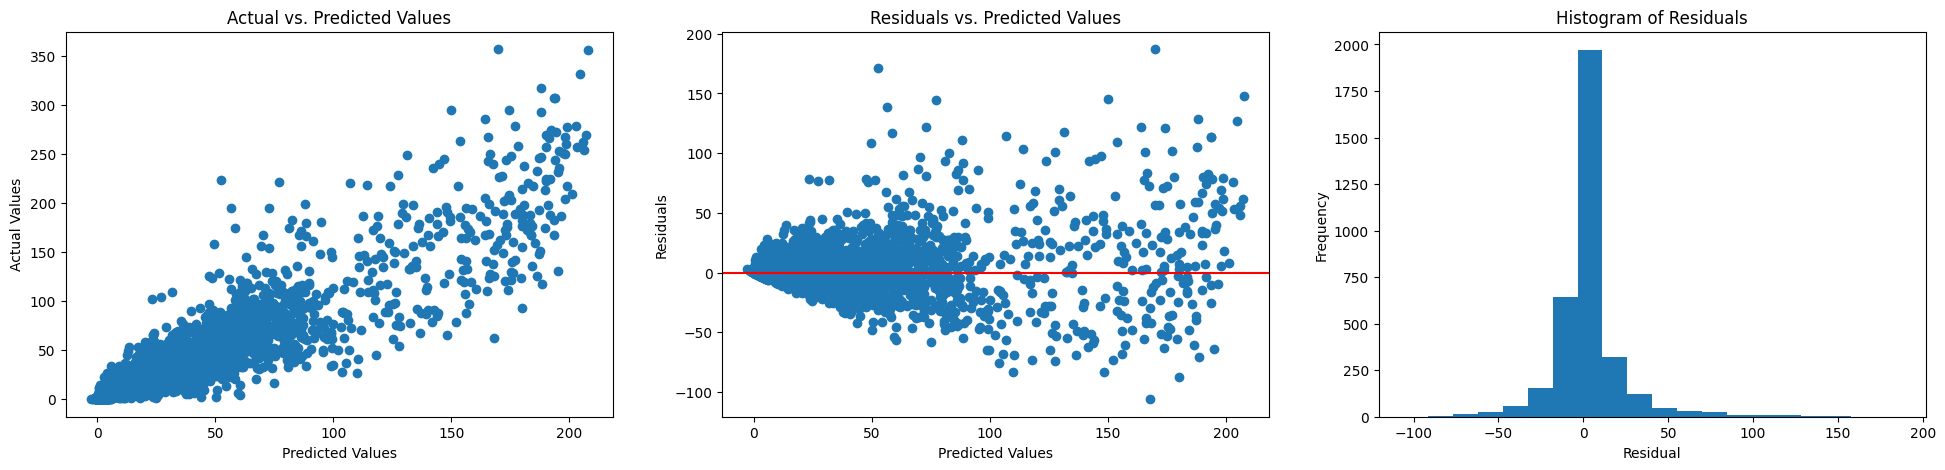

In [187]:
# Visualize errors
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 5))

ax1.scatter(y_pred.flatten(), y_test)
ax1.set_title('Actual vs. Predicted Values')
ax1.set_xlabel('Predicted Values')
ax1.set_ylabel('Actual Values')

residuals = y_test - y_pred.flatten()
ax2.scatter(y_pred.flatten(), residuals)
ax2.axhline(y=0, color='red')
ax2.set_title('Residuals vs. Predicted Values')
ax2.set_xlabel('Predicted Values')
ax2.set_ylabel('Residuals')

ax3.hist(residuals, bins=20)
ax3.set_xlabel('Residual')
ax3.set_ylabel('Frequency')
ax3.set_title('Histogram of Residuals')

plt.show()

In [188]:
# Generate predictions for holdout data
X_last_week = last_week_df[features_nonlinear]
y_last_week = last_week_df[target]
last_week_datetime = last_week_df['datetime']

last_week_preds = model.predict(
    [X_last_week['season'],
     X_last_week['hr'],
     X_last_week['mnth'],
     X_last_week['weekday'],
     X_last_week['weathersit'],
     X_last_week[numerical_features]
])

6/6 [==============================] - 0s 3ms/step


In [189]:
# Put predictions into a dataframe
last_week_preds_df = pd.DataFrame({
    'datetime': last_week_datetime.values,
    'casual_true': y_last_week.values,
    'casual_pred': np.maximum(0, np.round(last_week_preds).astype(int).flatten())
    }).reset_index(drop=True)

last_week_preds_df.tail()

datetime  casual_true  casual_pred
162 2012-12-31 19:00:00           11            4
163 2012-12-31 20:00:00            8            3
164 2012-12-31 21:00:00            7            4
165 2012-12-31 22:00:00           13            3
166 2012-12-31 23:00:00           12            3

In [190]:
# Export data for tableau
bike_sharing_df.to_csv('bike_sharing.csv')
last_week_preds_df.to_csv('causal_preds.csv')

# Experiments

Linear Model:
Reference: https://www.tensorflow.org/tutorials/structured_data/time_series#linear_model

In [ ]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [ ]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

NameError: name 'single_step_window' is not defined

In [ ]:
history2 = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

In [ ]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', linear(wide_window.example[0]).shape)

In [ ]:
wide_window.plot(linear)

In [ ]:
#Model weights
plt.figure(figsize=(20, 3))
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

Dense Model:
Reference: https://www.tensorflow.org/tutorials/structured_data/time_series#dense

In [ ]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])
# dense = tf.keras.Sequential([
#     tf.keras.layers.Dense(units=32, activation='relu'),
#     tf.keras.layers.Dense(units=32, activation='relu'),
#     tf.keras.layers.Dropout(.6)
# ])

history2 = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

In [ ]:
CONV_WIDTH = 3
conv_window = WindowSplit(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['cnt'])

conv_window

In [ ]:
conv_window.plot()
# plt.title("Given 3 inputs, predict 1 into the future.")

In [ ]:
wide_window.plot(dense)

In [ ]:
#Model weights
plt.figure(figsize=(20, 3))
plt.bar(x = range(len(train_df.columns)),
        height=dense.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

Multi-Step Dense:
Reference: https://www.tensorflow.org/tutorials/structured_data/time_series#multi-step_dense

In [ ]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [ ]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)

In [ ]:
history2 = compile_and_fit(multi_step_dense, conv_window)

val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

In [ ]:
conv_window.plot(multi_step_dense)

Convolution Neural Network CNN
Reference: https://www.tensorflow.org/tutorials/structured_data/time_series#convolution_neural_network

In [ ]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

In [ ]:
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

In [ ]:
history2 = compile_and_fit(conv_model, conv_window)

val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

In [ ]:
print("Wide window")
print('Input shape:', wide_window.example[0].shape)
print('Labels shape:', wide_window.example[1].shape)
print('Output shape:', conv_model(wide_window.example[0]).shape)

In [ ]:
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowSplit(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['cnt'])

wide_conv_window

In [ ]:
print("Wide conv window")
print('Input shape:', wide_conv_window.example[0].shape)
print('Labels shape:', wide_conv_window.example[1].shape)
print('Output shape:', conv_model(wide_conv_window.example[0]).shape)

In [ ]:
wide_conv_window.plot(conv_model)